## Table of content

1. Importing Libraries
2. Loading Data
3. Data Wrangling
4. Feature Selection using Correlation Matrix
5. Feature Selection using SelectKBest Method
6. Feature Selection using Extra Tree Classifier
7. Feature Engineering with BoxCox, Log, Min-Max and Standard transformation
8. Preparing data - Standardisation and Splitting
9. Prediction with XGBoost
10. Using MultiLayer Perceptron for prediction

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re 

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import chi2,SelectKBest

from sklearn.model_selection import train_test_split as tts

import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential 

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Loading Data 

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head(2)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


# Data Wrangling

In [5]:
df = data.copy()

In [6]:
st = '9/29/2016 12:00:00 AM'
st.split()[0]

'9/29/2016'

In [7]:
df['Data'] = df['Data'].apply(lambda x:x.split()[0])
df.sample(2)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
15760,1475461521,10/2/2016,16:25:21,303.23,54,30.40,101,90.51,5.62,06:14:00,18:10:00
12934,1476327021,10/12/2016,16:50:21,265.95,58,30.44,80,61.49,5.62,06:16:00,18:02:00


In [8]:
pd.to_datetime(df['Data'])

0       2016-09-29
1       2016-09-29
2       2016-09-29
3       2016-09-29
4       2016-09-29
           ...    
32681   2016-12-01
32682   2016-12-01
32683   2016-12-01
32684   2016-12-01
32685   2016-12-01
Name: Data, Length: 32686, dtype: datetime64[ns]

In [9]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['day'] = pd.to_datetime(df['Data']).dt.day

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [10]:
df.head(1)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26


In [11]:
x = '06:13:00' 
l = lambda x : re.findall(r'\d+',x)[1]
int(l(x))

13

In [12]:
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.findall(r'^\d+',x)[0]).astype(int)
df['riseminute'] = df['TimeSunRise'].apply(lambda x : re.findall(r'\d+',x)[1]).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.findall(r'^\d+',x)[0]).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.findall(r'\d+',x)[1]).astype(int)

In [13]:
df.sample(3)

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
12641,1476416122,10/13/2016,17:35:22,38.24,62,30.44,24,115.21,2.25,06:17:00,18:01:00,10,13,17,35,22,6,17,18,1
19841,1479400205,11/17/2016,06:30:05,3.71,51,30.43,20,176.73,14.62,06:32:00,17:43:00,11,17,6,30,5,6,32,17,43
6997,1472863804,9/2/2016,14:50:04,904.94,62,30.44,73,46.03,15.75,06:07:00,18:37:00,9,2,14,50,4,6,7,18,37


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int32  
 12  day                     32686 non-null  int32  
 13  Hour                    32686 non-null  int32  
 14  Minute                  32686 non-null

In [15]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace = True)

In [16]:
df.shape

(32686, 15)

In [17]:
df.head(3)

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13


In [18]:
df.isnull().sum().sum()

np.int64(0)

In [19]:
input_features = df.drop(['Radiation'],axis = 1)
target = df.Radiation

# Feature Selection Using Correlation Matrix

![My Image](https://www.gstatic.com/education/formulas2/553212783/en/correlation_coefficient_formula.svg)

- r	=	correlation coefficient
- xi	=	values of the x-variable in a sample
- x-bar	=	mean of the values of the x-variable
- yi	=	values of the y-variable in a sample
- y-bar	=	mean of the values of the y-variable


In [20]:
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


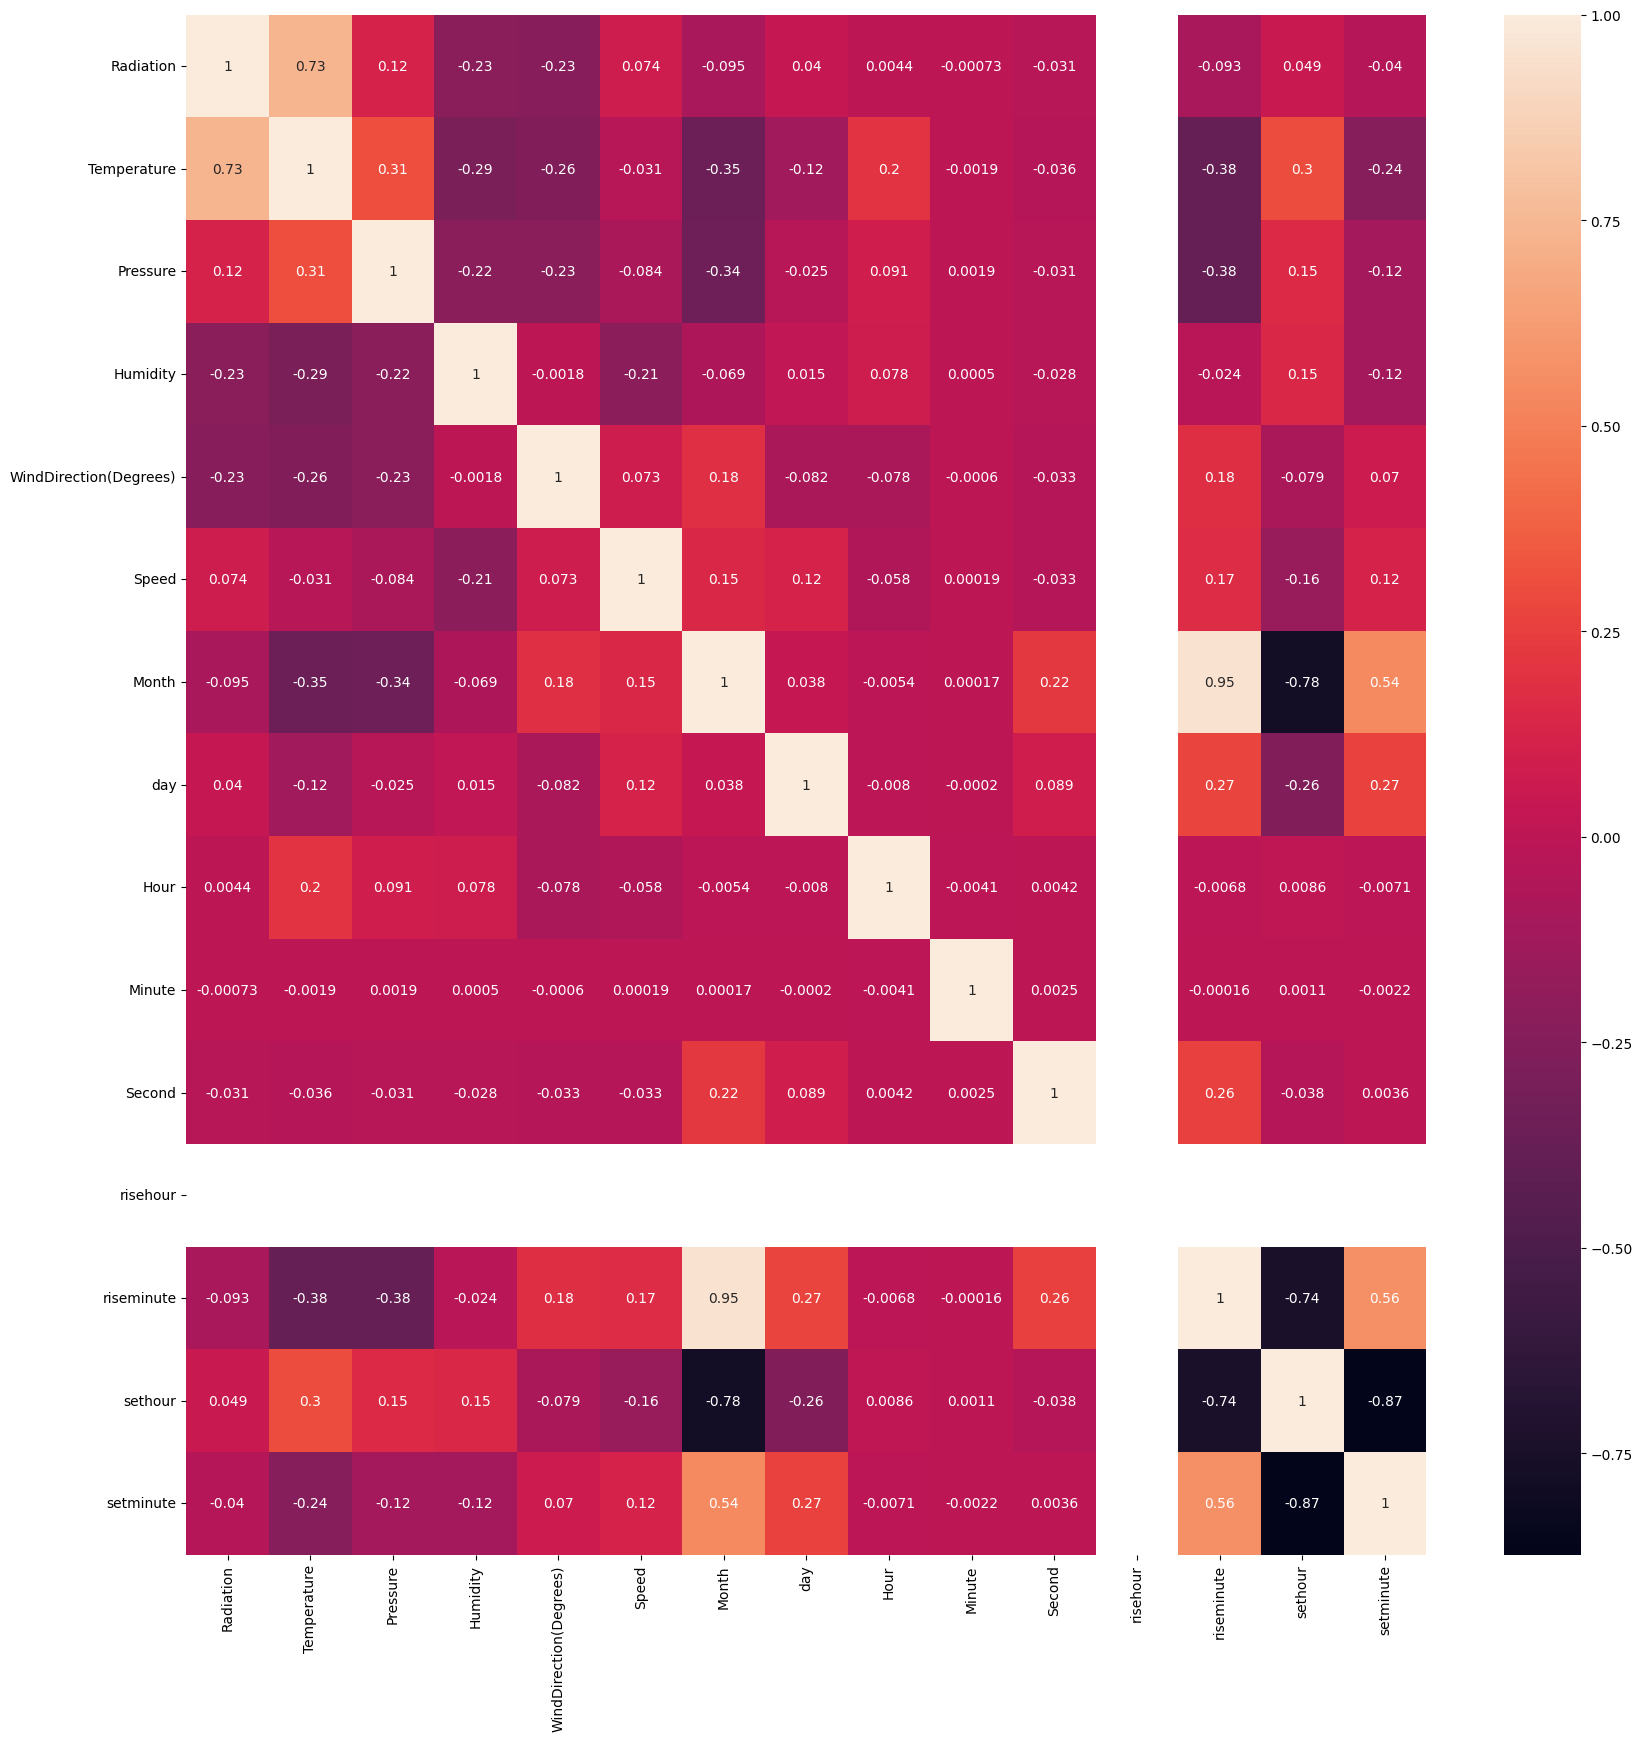

In [21]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,annot=True)
plt.show()

# Feature Selection using SelectKBest Method

In [22]:
from sklearn.preprocessing import LabelEncoder as LE
train_y = LE().fit_transform(target)

In [23]:
train_y

array([ 9,  9, 11, ...,  8, 11,  8])

In [24]:
target_cont = target.apply(lambda x :x *100).astype(int)
target_cont[:5]

0    121
1    121
2    123
3    121
4    117
Name: Radiation, dtype: int64

In [25]:
scaled_input_features = MinMaxScaler().fit_transform(input_features)

In [26]:
scaled_input_features

array([[0.37837838, 0.72972973, 0.53684211, ..., 0.12      , 1.        ,
        0.22033898],
       [0.37837838, 0.72972973, 0.52631579, ..., 0.12      , 1.        ,
        0.22033898],
       [0.37837838, 0.72972973, 0.51578947, ..., 0.12      , 1.        ,
        0.22033898],
       ...,
       [0.27027027, 0.62162162, 0.98947368, ..., 0.68      , 0.        ,
        0.71186441],
       [0.27027027, 0.62162162, 0.97894737, ..., 0.68      , 0.        ,
        0.71186441],
       [0.27027027, 0.64864865, 0.97894737, ..., 0.68      , 0.        ,
        0.71186441]])

In [27]:
best_features = SelectKBest(score_func = chi2, k = 10)

In [28]:
fit = best_features.fit(scaled_input_features,target_cont)

In [29]:
scores = pd.DataFrame(fit.scores_,index = input_features.columns,columns = ['Feature_Importance']).sort_values(by = 'Feature_Importance',ascending=False)
#columns = pd.DataFrame(input_features.columns)
#feature score
scores

,Feature_Importance
sethour,12207.531454
Month,4684.579610
riseminute,4015.062771
WindDirection(Degrees),3271.827277
day,2841.926850
Minute,2702.449333
Second,2288.673032
setminute,1863.712087
Temperature,1651.685632
Humidity,1588.087433


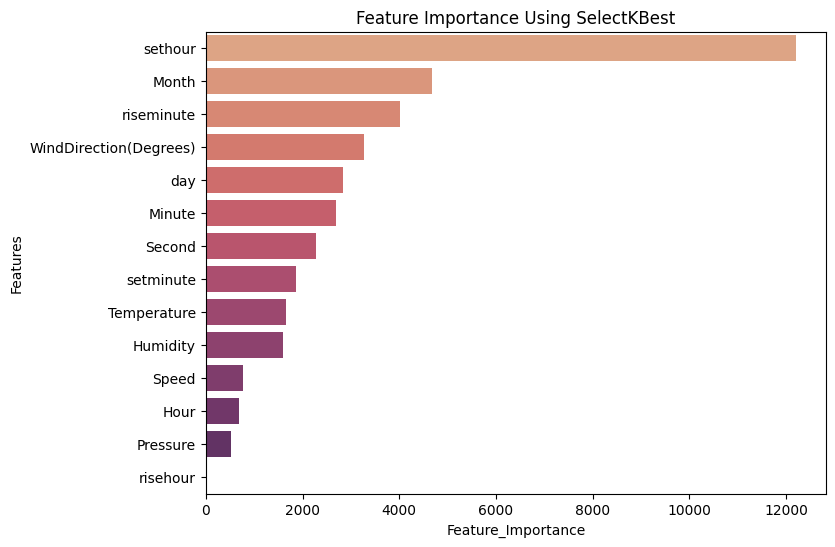

In [30]:
plt.figure(figsize=(8,6))
sns.barplot(y = scores.index , x = scores.Feature_Importance,palette ='flare')
plt.ylabel('Features')
#plt.xticks(rotation= 90)
plt.title('Feature Importance Using SelectKBest')
plt.show()

# Feature Importance Using ExtraTreeClassifier

In [31]:
model = ExtraTreesClassifier(n_estimators= 20,max_depth = 10,verbose = 2)
model.fit(scaled_input_features,target_cont)

building tree 1 of 20
building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.3s finished


ExtraTreesClassifier(max_depth=10, n_estimators=20, verbose=2)

In [32]:
scores_ET = pd.DataFrame(model.feature_importances_,index = input_features.columns,columns = ['Feature IMP.']).sort_values(by = 'Feature IMP.',ascending = False)
scores_ET

,Feature IMP.
Hour,0.213662
Temperature,0.144377
WindDirection(Degrees),0.089568
riseminute,0.079244
day,0.076838
setminute,0.071299
Humidity,0.065637
Pressure,0.061795
Second,0.049588
Speed,0.046470


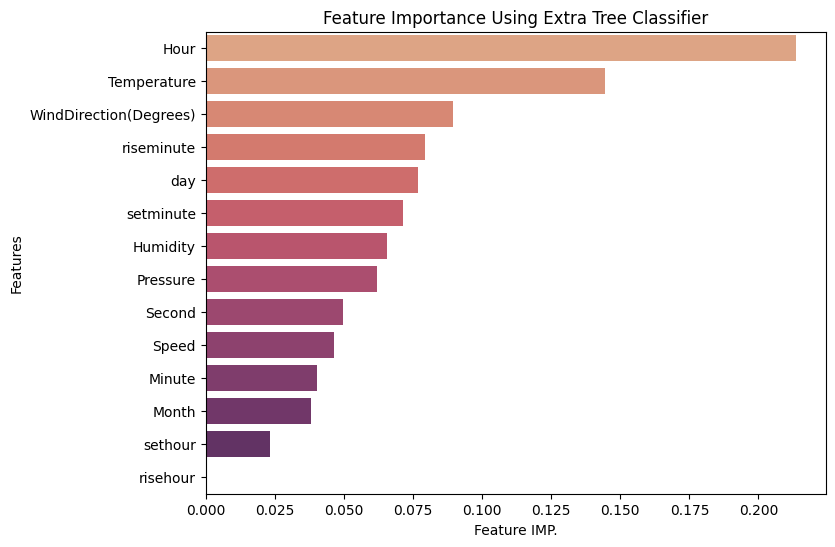

In [33]:
plt.figure(figsize=(8,6))
sns.barplot(y = scores_ET.index , x = scores_ET['Feature IMP.'],palette ='flare')
plt.ylabel('Features')
#plt.xticks(rotation= 90)
plt.title('Feature Importance Using Extra Tree Classifier')
plt.show()

# Feature engineering with BoxCox,Log,Min-Max and Standard transformation 

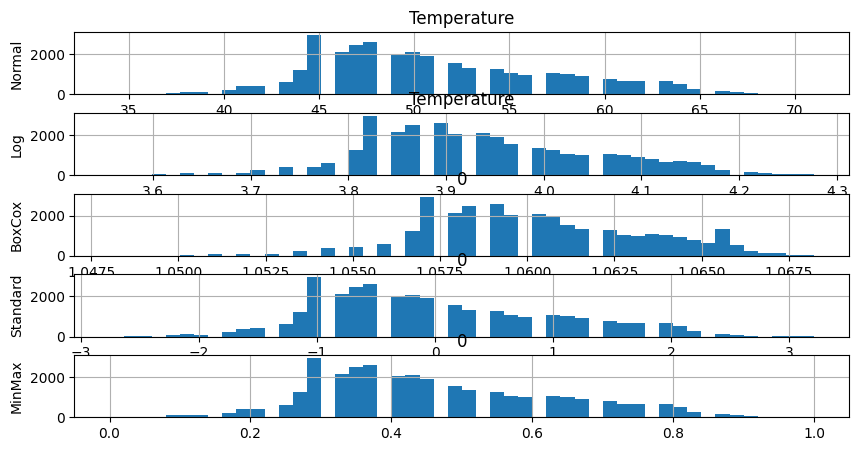

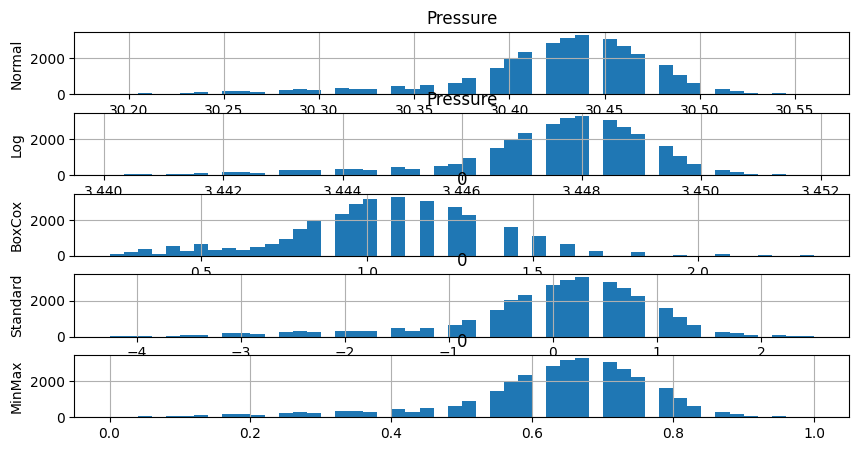

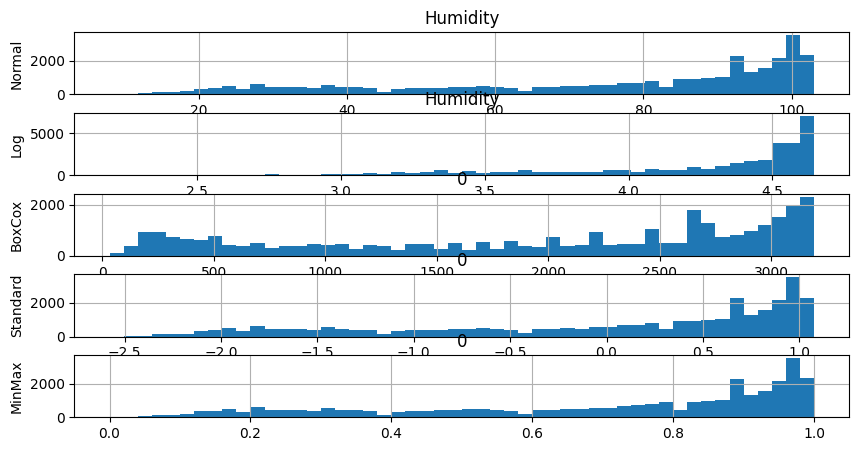

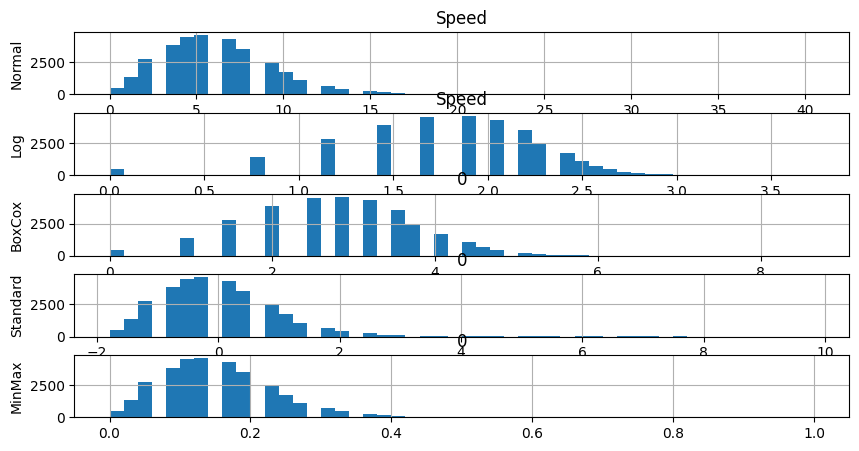

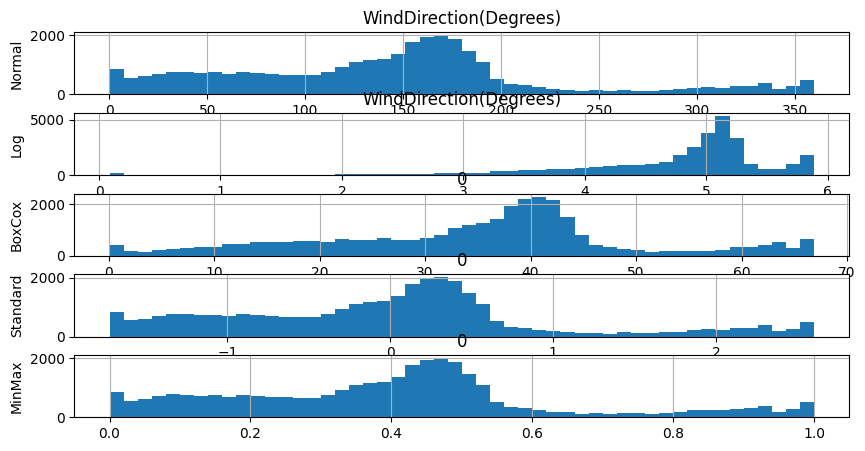

In [34]:
features_to_transform = ['Temperature' ,'Pressure','Humidity','Speed','WindDirection(Degrees)']

for i in features_to_transform:
    
    fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(10,5))
    pd.DataFrame(input_features[i]).hist(ax=ax1,bins=50)
    pd.DataFrame(input_features[i]+1).transform(np.log).hist(ax=ax2,bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3,bins=50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax4,bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax=ax5,bins=50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('BoxCox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

In [35]:
transform = {'Temperature':(input_features['Temperature']+1).transform(np.log),
            'Pressure':stats.boxcox(input_features['Pressure']+1)[0],
             'Humidity':stats.boxcox(input_features['Humidity']+1)[0],
             'Speed':(input_features['Speed']+1).transform(np.log),
             'WindDirection(Degrees)':MinMaxScaler().fit_transform(np.array(input_features['WindDirection(Degrees)']).reshape(-1,1))} 

In [36]:
input_features.head(3)

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13


In [37]:
for i in transform:
    input_features[i] = transform[i]

In [38]:
input_features.head(3)

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,day,Hour,Minute,Second,risehour,riseminute,sethour,setminute
0,3.89182,1.245832e+297,1139.358153,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,1.245832e+297,1104.046486,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,1.245832e+297,1069.253069,0.440894,1.474763,9,29,23,45,26,6,13,18,13


In [39]:
s = pd.Series([1,2,3,4])
np.array(s).reshape(-1,1)

array([[1],
       [2],
       [3],
       [4]])

# Preparing Data - Standardisation and Splitting

In [40]:
xtrain,xtest,ytrain,ytest = tts(input_features,target,test_size=0.2,random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [41]:
xtrain.shape,xtest.shape

((26148, 14), (6538, 14))

# XGBoost

In [42]:
from xgboost import XGBRegressor

params = {
    'learning_rate':0.1,
    'max_depth':8
}
# same as # model = XGBRegressor(learning_rate=0.1, max_depth=8)
model = XGBRegressor(**params)

In [43]:
model.fit(xtrain,ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
ypred = model.predict(xtest)

In [45]:
rmse = np.sqrt(mean_squared_error(ypred,ytest))
r2 = r2_score(ypred,ytest)
rmse,r2

(np.float64(82.99447188040851), 0.9241415745084294)

# Using MultiLayer Preceptron for prediction 

In [48]:
model = None
model = Sequential()

model.add(Dense(128,activation='relu',input_dim = 14))
model.add(Dropout(0.33))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1,activation='sigmoid'))

model.compile(metrics=['mse'],
              loss='mae',
              optimizer='Adam')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 128)                 │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit(xtrain,ytrain, validation_split=0.1, epochs = 50, batch_size=256)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 210.8099 - mse: 145317.5781 - val_loss: 203.7067 - val_mse: 136524.4219
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 209.3352 - mse: 145643.6719 - val_loss: 203.6838 - val_mse: 136515.1094
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 208.4413 - mse: 143573.8906 - val_loss: 203.6613 - val_mse: 136505.9219
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 208.9640 - mse: 143977.0625 - val_loss: 203.6392 - val_mse: 136496.9375
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 208.6150 - mse: 144331.8594 - val_loss: 203.6177 - val_mse: 136488.1562
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 210.2038 - mse: 145410.2500 - val_loss: 203.5969 - val_mse: 136479.6719
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 211.7747 - mse: 146485.4531 - val_loss: 203.5768 - val_mse: 136471.5000
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 208.3193 - mse: 145095.3750 - va

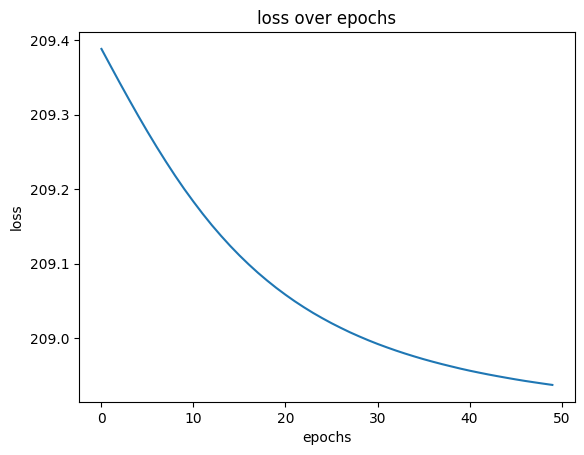

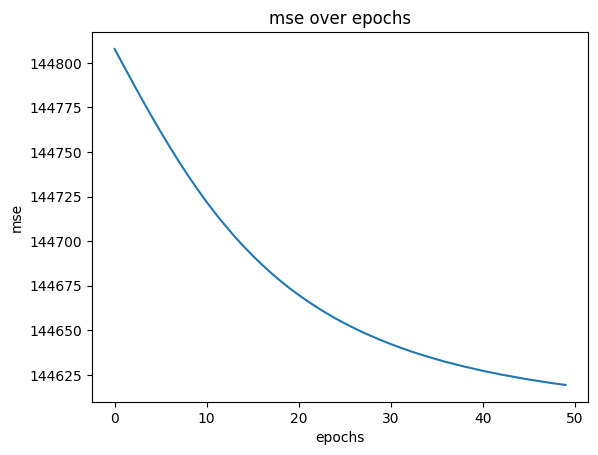

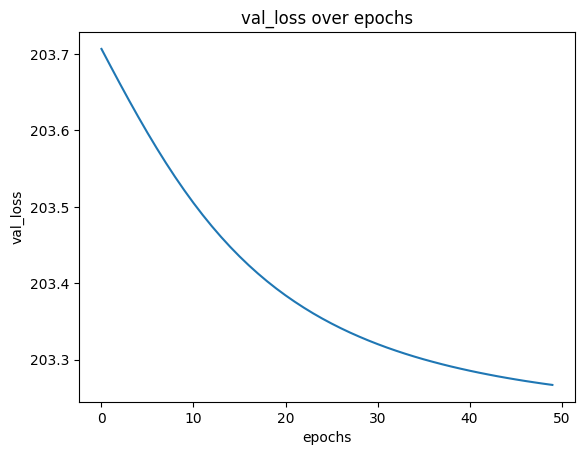

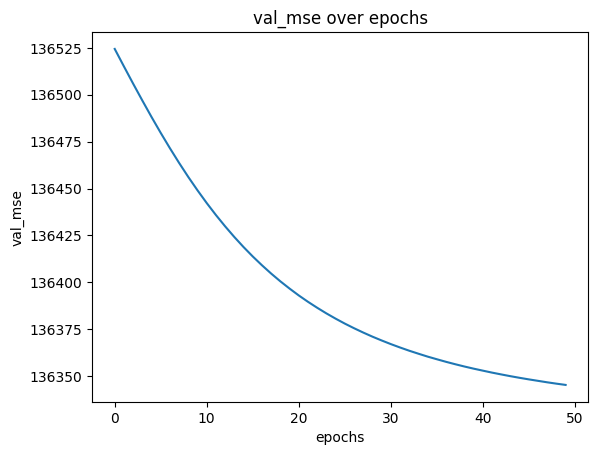

In [50]:
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i + ' over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [53]:
ypred = model.predict(xtest)

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [54]:
mean_absolute_error(ypred,ytest)

197.3324320570385